In [1]:
import rospy
import numpy as np
import sensor_msgs.point_cloud2 as pc2
from cv_bridge import CvBridge

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
import rosbag
bag = rosbag.Bag('raw_data.bag')
topics = bag.get_type_and_topic_info()[1].keys()
types = []
for i in range(0,len(bag.get_type_and_topic_info()[1].values())):
    types.append(bag.get_type_and_topic_info()[1].values()[i][0])
print(topics)
print(types)

bridge = CvBridge()
cmd_list = []
cmd_time = []
pcl_list = []
pcl_time = []
imu_list = []
imu_time = []
img_list = []
img_time = []

for topic, msg, t in bag.read_messages():
        
    if '/vehicle/cmd_vel'==topic:
        cmd_t = np.zeros((2,))
        cmd_t[0] = msg.angular.z
        cmd_t[1] = msg.linear.x
        cmd_list.append(cmd_t)
        cmd_time.append(t)

    if '/vehicle/imu/data_raw'==topic:
        imu_t = np.zeros((4+3+3,))

        imu_t[0] = msg.orientation.x
        imu_t[1] = msg.orientation.y
        imu_t[2] = msg.orientation.z
        imu_t[3] = msg.orientation.w

        imu_t[4] = msg.angular_velocity.x
        imu_t[5] = msg.angular_velocity.y
        imu_t[6] = msg.angular_velocity.z

        imu_t[7] = msg.linear_acceleration.x
        imu_t[8] = msg.linear_acceleration.y
        imu_t[9] = msg.linear_acceleration.z
        imu_list.append(imu_t)
        imu_time.append(t)
        
    if '/vehicle/front_camera/image_rect_color'==topic:
        frame_t = bridge.imgmsg_to_cv2(msg, "bgr8")
        frame_t = np.array(frame_t, dtype=np.uint8)
        img_list.append(frame_t)
        img_time.append(t)

    if '/vehicle/velodyne_points'==topic:            
        pc_t = []
        for p in pc2.read_points(msg,skip_nans=True,field_names=("x","y","z")):
            pc_t.append(np.asarray(p))
        
        print(np.max(np.asarray(pc_t),axis=0))
        pcl_list.append(np.asarray(pc_t))
        pcl_time.append(t)

cmd_list = np.asarray(cmd_list)
cmd_time = np.asarray(cmd_time)
pcl_list = np.asarray(pcl_list)
pcl_time = np.asarray(pcl_time)
imu_list = np.asarray(imu_list)
imu_time = np.asarray(imu_time)
img_list = np.asarray(img_list)
img_time = np.asarray(img_time)
bag.close()

['/vehicle/cmd_vel', '/vehicle/velodyne_points', '/vehicle/front_camera/image_rect_color', '/vehicle/imu/data_raw']
['geometry_msgs/Twist', 'sensor_msgs/PointCloud2', 'sensor_msgs/Image', 'sensor_msgs/Imu']
[93.04902649 93.61198425 -0.2027089 ]
[93.29959106 93.24209595 -0.2027238 ]
[93.21759033 93.33423615 -0.20275718]
[93.29883575 93.21784973 -0.20264743]
[93.18140411 93.21551514 -0.20499749]
[93.21820068 93.26977539 -0.20339739]
[93.33216095 93.27832794 -0.20318335]
[93.22242737 93.38656616 -0.203272  ]
[93.29627991 93.25767517 -0.20270941]
[93.21929169 93.28252411 -0.20364405]
[93.19377899 93.29689026 -0.20293628]
[93.16604614 93.20731354 -0.20303518]
[93.2463913  93.2771759  -0.20300893]
[93.36000824 93.27766418 -0.20261844]
[93.30387115 93.22665405 -0.20332558]
[93.06014252 93.45589447 -0.20364416]
[93.0032196  93.43817139 -0.20451364]
[93.0063324  93.37911987 -0.20283413]
[93.01902771 93.38155365 -0.20306045]
[92.99886322 93.36460876 -0.20246156]
[92.79517365 93.37281799 -0.20327

In [3]:
print(img_time.shape)
print(cmd_time.shape)
print(pcl_time.shape)
print(imu_time.shape)

(656,)
(1082,)
(216,)
(2165,)


In [4]:
def find_nearest(x1,x2):
    len1 = x1.shape[0]
    len2 = x2.shape[0]
    dist = np.abs(np.tile(x1[np.newaxis,:],reps=(len2,1)) - np.tile(x2[:,np.newaxis],reps=(1,len1)))
    arg2 = np.argmin(dist,axis=0)
    return arg2

img_list = img_list[find_nearest(pcl_time,img_time)]
cmd_list = cmd_list[find_nearest(pcl_time,cmd_time)]
imu_list = imu_list[find_nearest(pcl_time,imu_time)]

In [5]:
cmd_list = np.asarray(cmd_list)
imu_list = np.asarray(imu_list)
img_list = np.asarray(img_list)

In [6]:
print(img_list.shape)
print(cmd_list.shape)
print(pcl_list.shape)
print(imu_list.shape)

(216, 800, 800, 3)
(216, 2)
(216,)
(216, 10)


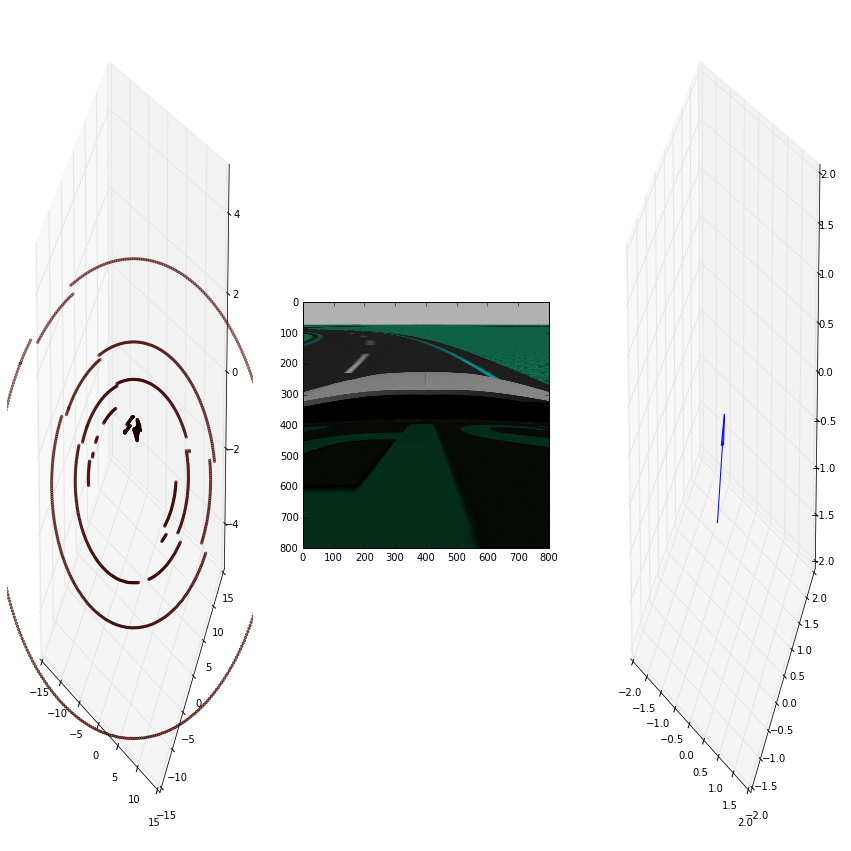

In [7]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(131, projection='3d')
pcl = pcl_list[3]
ax1.scatter(pcl[:,0],pcl[:,1],zs=pcl[:,2],c='r',marker='.')
ax1.set_zlim(-5,5)
plt.xlim([-15, 15])
plt.ylim([-15, 15])
# ax1.view_init(60,30)
fig.add_subplot(132)
plt.imshow(img_list[3])
ax3 = fig.add_subplot(133, projection='3d')
ax3.quiver(0,0,0,imu_list[3][7],imu_list[3][8],imu_list[3][9])
ax3.set_zlim(-2,2)
ax3.set_xlim(-2,2)
ax3.set_ylim(-2,2)
plt.show()

In [8]:
import pickle

print(img_list.shape)
print(cmd_list.shape)
print(pcl_list.shape)
print(imu_list.shape)

training_data = {'imu_list': imu_list, 'cmd_list':cmd_list, 'img_list':img_list, 'pcl_list':pcl_list}

with open('training_data.pkl', 'wb') as handle:
    pickle.dump(training_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

(216, 800, 800, 3)
(216, 2)
(216,)
(216, 10)
